<a href="https://colab.research.google.com/github/RobsonPalerma/energy_consumption.csv/blob/main/Etapa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import files
uploaded = files.upload()

Saving energy_consumption (4).csv to energy_consumption (4) (1).csv


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
pd.set_option('display.max_columns', None)

print("✅ Imports concluídos!")


✅ Imports concluídos!


In [88]:
df = pd.read_csv("energy_consumption (4).csv")
print(f"Dataset carregado: {df.shape}")
df.head()


Dataset carregado: (2510, 17)


,house_id,house_area_sqm,num_residents,num_appliances,air_conditioning,heating_system,energy_efficiency_rating,avg_temperature,home_office_hours,has_pool,solar_panels,house_age_years,insulation_quality,num_rooms,electric_car,smart_thermostat,monthly_consumption_kwh
0,HOUSE02311,195.78,5,26.0,2,Electric,C,40.00,8.0,No,Yes,4.0,Good,4,No,Yes,595.84
1,HOUSE01565,109.37,4,13.0,NaN,NaN,B,8.68,0.0,No,No,33.0,Average,5,No,yes,328.93
2,HOUSE02471,158.97,1,7.0,2,Gas,C,21.72,0.0,No,No,NaN,Good,8,No,Yes,308.77
3,HOUSE02286,155.23,3,6.0,3+,Gas,B,10.66,8.0,No,No,5.0,Good,6,No,No,392.40
4,HOUSE00978,NaN,4,8.0,1,Gas,E,25.83,0.0,Yes,No,6.0,Poor,8,No,Yes,485.11


In [89]:
missing_total = df.isnull().sum().sum()
print(f"Missing values: {missing_total}")

if missing_total == 0:
    print("✅ Dataset limpo! Etapa 2 concluída corretamente.")
else:
    print("⚠️ Missing encontrados! Preenchendo valores numéricos com mediana…")
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col].fillna(df[col].median(), inplace=True)
    print(f"Missing restantes: {df.isnull().sum().sum()}")


Missing values: 2720
⚠️ Missing encontrados! Preenchendo valores numéricos com mediana…
Missing restantes: 1568


In [90]:
target_col = "monthly_consumption_kwh"

X = df.drop(columns=[target_col])   # remover target
y = df[target_col]

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")


Features: (2510, 16)
Target: (2510,)


In [91]:
# PASSO 1 — Separar TESTE (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

# PASSO 2 — Separar TREINO (60%) e VALIDAÇÃO (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 25% dos 80% = 20% do total
    random_state=42
)


In [92]:
print("="*60)
print("RESUMO DA DIVISÃO DOS DADOS")
print("="*60)
print(f"Treino:     {len(X_train)} amostras (60%)")
print(f"Validação:  {len(X_val)} amostras (20%)")
print(f"Teste:      {len(X_test)} amostras (20%)")
print("="*60)


RESUMO DA DIVISÃO DOS DADOS
Treino:     1506 amostras (60%)
Validação:  502 amostras (20%)
Teste:      502 amostras (20%)


In [93]:
stats_df = pd.DataFrame({
    "Treino": y_train.describe(),
    "Validação": y_val.describe(),
    "Teste": y_test.describe()
})

print(stats_df.round(2))


        Treino  Validação   Teste
count  1506.00     502.00  502.00
mean    405.10     403.38  403.87
std     100.62      92.23   93.71
min     134.75     145.22  176.83
25%     338.75     342.44  340.40
50%     400.00     398.82  396.56
75%     466.65     461.21  464.59
max    1083.20     728.25  795.82


In [94]:
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['house_area_sqm', 'num_residents', 'num_appliances', 'avg_temperature', 'home_office_hours', 'house_age_years', 'num_rooms']
Categóricas: ['house_id', 'air_conditioning', 'heating_system', 'energy_efficiency_rating', 'has_pool', 'solar_panels', 'insulation_quality', 'electric_car', 'smart_thermostat']


In [95]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

model = LinearRegression()

pipeline = Pipeline([
    ("prep", preprocess),
    ("lr", model)
])


In [96]:
pipeline.fit(X_train, y_train)
print("✅ Modelo treinado!")


✅ Modelo treinado!


In [97]:
pred_train = pipeline.predict(X_train)
pred_val = pipeline.predict(X_val)


In [98]:
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_train, mae_train, r2_train = metrics(y_train, pred_train)
rmse_val, mae_val, r2_val = metrics(y_val, pred_val)

print("\n🎯 MÉTRICAS DO MODELO BASELINE")
print("="*50)
print(f"Treino — R²: {r2_train:.3f} | RMSE: {rmse_train:.2f} | MAE: {mae_train:.2f}")
print(f"Validação — R²: {r2_val:.3f} | RMSE: {rmse_val:.2f} | MAE: {mae_val:.2f}")



🎯 MÉTRICAS DO MODELO BASELINE
Treino — R²: 1.000 | RMSE: 0.38 | MAE: 0.12
Validação — R²: 0.832 | RMSE: 37.75 | MAE: 29.58


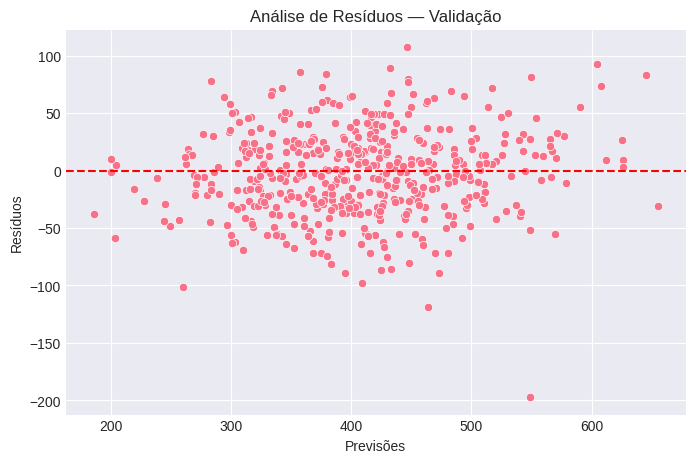

In [99]:
residuos = y_val - pred_val

plt.figure(figsize=(8,5))
sns.scatterplot(x=pred_val, y=residuos)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Previsões")
plt.ylabel("Resíduos")
plt.title("Análise de Resíduos — Validação")
plt.show()


In [100]:
onehot = pipeline.named_steps["prep"].named_transformers_["cat"]
encoded_cols = onehot.get_feature_names_out(categorical_cols)

all_features = list(encoded_cols) + numeric_cols

coefs = pipeline.named_steps["lr"].coef_

feat_imp = pd.DataFrame({
    "feature": all_features,
    "coef": coefs
}).sort_values(by="coef", ascending=False)

feat_imp.head(20)


,feature,coef
352,house_id_HOUSE00576,733.805588
267,house_id_HOUSE00422,640.230549
641,house_id_HOUSE01076,615.361311
918,house_id_HOUSE01547,520.901694
1472,house_id_HOUSE02459,457.692272
933,house_id_HOUSE01572,118.577910
89,house_id_HOUSE00132,112.058362
948,house_id_HOUSE01597,109.917109
811,house_id_HOUSE01372,109.485925
990,house_id_HOUSE01668,103.340056


In [101]:
print("R² Treino:", r2_train)
print("R² Validação:", r2_val)

gap = r2_train - r2_val

print(f"\nDiferença (gap) = {gap:.3f}")

if gap < 0.05:
    print("✅ Modelo sem sinais de overfitting.")
elif gap < 0.15:
    print("⚠️ Overfitting leve.")
else:
    print("❌ Overfitting alto — melhorar modelo.")


R² Treino: 0.9999855049881795
R² Validação: 0.8321263902845486

Diferença (gap) = 0.168
❌ Overfitting alto — melhorar modelo.


In [103]:
os.makedirs("modelos", exist_ok=True)

joblib.dump(pipeline, "modelos/modelo_baseline_energy.pkl")
print(" Modelo salvo em: modelos/modelo_baseline_energy.pkl")


 Modelo salvo em: modelos/modelo_baseline_energy.pkl
